

What's differentiate metric learning from traditional classification is that we train the model to learn a compact representation

how to have examples of the same classes to be close together and the one f


References
- Original paper:
FaceNet: A Unified Embedding for Face Recognition and Clustering
https://arxiv.org/abs/1503.03832 

- Mining strategies:
https://openaccess.thecvf.com/content_WACV_2020/papers/Xuan_Improved_Embeddings_with_Easy_Positive_Triplet_Mining_WACV_2020_paper.pdf 


In [1]:
 %load_ext autoreload
 %autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  TensorBoard
# from tqdm.auto import tqdm
from time import  time
from tabulate import tabulate
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

In [5]:
from tensorflow_similarity.utils import tf_cap_memory
from tensorflow_similarity.losses import TripletLoss
from tensorflow_similarity.layers import MetricEmbedding
from tensorflow_similarity.model import SimilarityModel
from tensorflow_similarity.indexer import Indexer
from tensorflow_similarity.visualization import  viz_neigbors_imgs

In [6]:
tf_cap_memory()
print(tf.__version__)

2.3.1


# preparing data

Note: Tensorflow similarity expect y_train to be the examples class as integer so there is no need for processing

In [155]:
# FIXME sampler here and select only half of the class

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = tf.constant(x_train / 255.0)
x_test = tf.constant(x_test / 255.0)
print('x_train', x_train.shape)
print('y_train', y_train.shape)

x_train (60000, 28, 28)
y_train (60000,)


# model creation

In [8]:
def get_model():
    tf.keras.backend.clear_session()
    inputs = tf.keras.layers.Input(shape=(28,28))
    x = layers.Reshape((28,28,1))(inputs)
    x = layers.Conv2D(16, 3, activation='relu')(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = MetricEmbedding(10)(x)
    # outputs2 = MetricEmbedding(10)(x)
    return SimilarityModel(inputs, outputs)
model = get_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)          

# Compilation

In [9]:

distance = 'cosine' #@param ["cosine"]{allow-input: false}
positive_mining_strategy = 'hard' #@param ["easy", "hard"]{allow-input: false}
negative_mining_strategy = 'semi-hard' #@param ["easy", "hard"]{allow-input: false}
triplet_loss = TripletLoss(distance=distance,
    positive_mining_strategy=positive_mining_strategy,
    negative_mining_strategy=negative_mining_strategy)

# Training

In [49]:
model = get_model()
# model.compile(optimizer='adam', loss=triplet_loss)
history = model.compile(optimizer='adam', loss=triplet_loss)


EPOCHS = 5 #@param{Integer}
BATCH_SIZE = 8 #@param{Integer}
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
7500/7500 [==============================] - 16s 2ms/step - loss: 0.1300 - val_loss: 0.0534
Epoch 2/5
7500/7500 [==============================] - 16s 2ms/step - loss: 0.0517 - val_loss: 0.0383
Epoch 3/5
7500/7500 [==============================] - 16s 2ms/step - loss: 0.0386 - val_loss: 0.0358
Epoch 4/5
7500/7500 [==============================] - 16s 2ms/step - loss: 0.0317 - val_loss: 0.0353
Epoch 5/5
7500/7500 [==============================] - 16s 2ms/step - loss: 0.0297 - val_loss: 0.0294


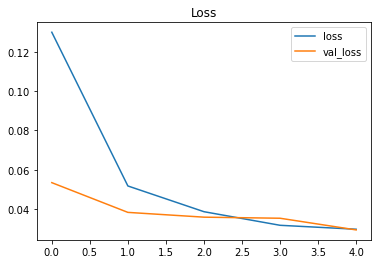

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.show()

# Indexing

## computing embeddings

In [52]:
num_embeddings = 10000
embeddings = model.predict(x_train[:num_embeddings])
labels = y_train[:num_embeddings]
data = x_train[:num_embeddings]
print(data.shape)

(10000, 28, 28)


## Building the index 
We need to use an indexer to be able to lookup our embeddings

In [53]:
# creating a new index
indx = Indexer()

# adding our embedding and metadata to index. Note: labels and data a
# are optional
indx.batch_add(embeddings, labels, data)

## Testing

In [55]:
# computing embeddings with our training model
test_embeddings = model.predict(x_test)
print(test_embeddings.shape)

(10000, 10)


In [60]:
target_id = 100
num_neighboors = 10


# semantic sugar to make it easier to follow along
target = test_embeddings[target_id]
target_label = y_test[target_id]
target_data = x_test[target_id]

# query the index for one of the test_embedding
neighboors = indx.lookup(target, k=num_neighboors)

# display results
print('expected label: ', target_label)

print('\n[Nearest embeddings]\n')
rows = [[n['label'], n['distance']] for n in neighboors]
print(tabulate(rows, headers=['label', 'distances']))

expected label:  6

[Nearest embeddings]

  label    distances
-------  -----------
      6  6.31809e-06
      6  3.42727e-05
      6  4.03523e-05
      6  4.45843e-05
      6  7.12276e-05
      6  7.46846e-05
      6  7.52211e-05
      6  8.77976e-05
      6  0.000102818
      6  0.000107527


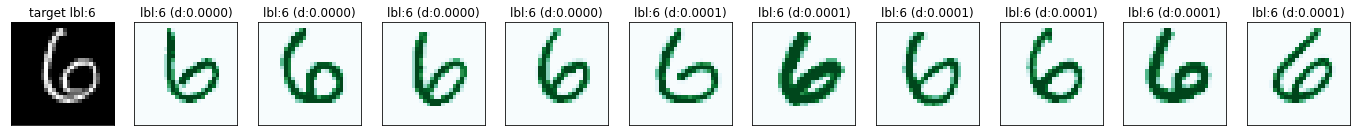

In [61]:
viz_neigbors_imgs(target_data, target_label, neighboors)

In [62]:
indx.print_stats()

[Index statistics]
----------------  -----
query_time            0
query                 0
num_lookups           5
num_items         10000
stat_buffer_size    100
----------------  -----

[Query performance]
------  -
min     0
max     0
avg     0
median  0
stddev  0
------  -
